<a href="https://colab.research.google.com/github/Pasindu457825/Deep-Learning-Lab_07/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [12]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [13]:
class GridWorld:
    def __init__(self):
        self.height = 8
        self.width  = 8
        self.grid   = np.zeros((self.height, self.width)) - 1  # step cost -1

        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        self.grid[self.bomb_location] = -10
        self.grid[self.gold_location] =  10

        self.actions = ['UP','DOWN','LEFT','RIGHT']
        self.reset()

    def reset(self):
        self.current_location = (4, np.random.randint(0,5))
        self.agent_position   = self.current_location  # alias for agent code
        return self.current_location

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location] = 1
        return grid

    def get_reward(self, loc):
        return self.grid[loc[0], loc[1]]

    def make_step(self, action):
        last = self.current_location
        x, y = last

        if action == 'UP':
            x = max(0, x-1)
        elif action == 'DOWN':
            x = min(self.height-1, x+1)
        elif action == 'LEFT':
            y = max(0, y-1)
        elif action == 'RIGHT':
            y = min(self.width-1, y+1)

        self.current_location = (x, y)
        self.agent_position   = self.current_location   # keep alias updated
        reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        return 'TERMINAL' if self.current_location in self.terminal_states else 'NON_TERMINAL'


In [14]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [15]:
import numpy as np
import random

class Q_Agent:
    # Initialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = {}
        for x in range(environment.height):
            for y in range(environment.width):
                self.q_table[(x, y)] = {'UP': 0.0, 'DOWN': 0.0, 'LEFT': 0.0, 'RIGHT': 0.0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """
        Epsilon-greedy action selection.
        If multiple optimal actions exist, choose randomly among the best.
        """
        #type your code here
        # get current state from environment (adjust attribute name if different)
        state = getattr(self.environment, "agent_position", None)
        if state is None:
            state = getattr(self.environment, "agent_pos", None)
        if state is None:
            raise ValueError("Environment must expose current state as 'agent_position' or 'agent_pos'.")

        # explore
        if np.random.rand() < self.epsilon:
            return random.choice(available_actions)

        # exploit
        q_at_state = self.q_table[state]
        max_q = max(q_at_state[a] for a in available_actions)
        best_actions = [a for a in available_actions if q_at_state[a] == max_q]
        return random.choice(best_actions)

    def learn(self, old_state, reward, new_state, action):
        """
        Q-learning update:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') − Q(s,a) ]
        """
        #typr your code here
        q_sa = self.q_table[old_state][action]

        if new_state in self.q_table:                 # if terminal not in table, treat as 0
            next_max = max(self.q_table[new_state].values())
        else:
            next_max = 0.0

        target = reward + self.gamma * next_max
        self.q_table[old_state][action] = q_sa + self.alpha * (target - q_sa)


In [16]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    reward_per_episode = []

    for _ in range(trials):
        environment.reset()
        cumulative_reward = 0.0
        step = 0
        game_over = False

        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location
            action = agent.choose_action(environment.get_available_actions())
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn:
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL':
                game_over = True

        reward_per_episode.append(cumulative_reward)

    return reward_per_episode


## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [17]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = (5, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

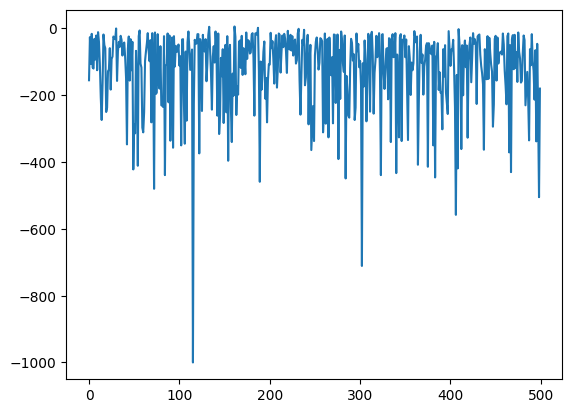

In [18]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

In [19]:
import numpy as np
import random

class Q_Agent:
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1.0):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # Q-table init
        self.q_table = {}
        for x in range(environment.height):
            for y in range(environment.width):
                self.q_table[(x, y)] = {'UP':0.0, 'DOWN':0.0, 'LEFT':0.0, 'RIGHT':0.0}

    def _get_state_from_env(self):
        for name in ("agent_position","agent_pos","state","current_state"):
            if hasattr(self.environment, name):
                return getattr(self.environment, name)
        if hasattr(self.environment, "get_state"):
            return self.environment.get_state()
        raise ValueError("Expose current state as env.agent_position or provide get_state().")

    def choose_action(self, available_actions):
        state = self._get_state_from_env()
        if np.random.rand() < self.epsilon:          # explore
            return random.choice(available_actions)
        q = self.q_table[state]                       # exploit
        m = max(q[a] for a in available_actions)
        best = [a for a in available_actions if q[a] == m]
        return random.choice(best)

    def learn(self, old_state, reward, new_state, action):
        q_sa = self.q_table[old_state][action]
        next_max = max(self.q_table[new_state].values()) if new_state in self.q_table else 0.0
        target = reward + self.gamma * next_max
        self.q_table[old_state][action] = q_sa + self.alpha * (target - q_sa)


Print the final Q-value table with nice formatting.

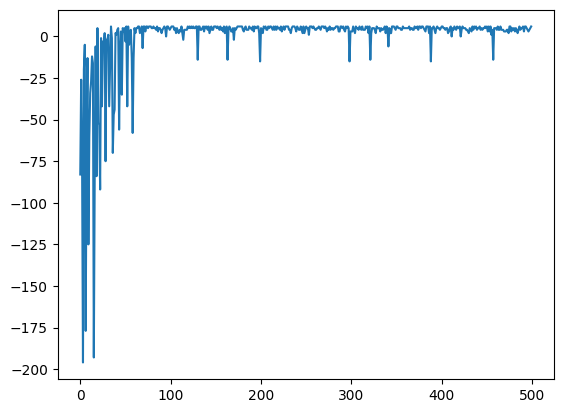

In [20]:
environment = GridWorld()
agentQ = Q_Agent(environment)
reward_per_episode = play(environment, agentQ, trials=500, learn=True)
plt.plot(reward_per_episode)


In [21]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.4261162827
	LEFT
		-0.4
	RIGHT
		-0.36910000000000004
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.21
	RIGHT
		4.5097724994586805
(0, 2)
	UP
		4.216731303486404
	DOWN
		3.2106398797708917
	LEFT
		0.7018768819517356
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0.0
	DOWN
		0.0
	LEFT
		0.0
	RIGHT
		0.0
(0, 4)
	UP
		0.0
	DOWN
		1.56331579631326
	LEFT
		9.99980636740211
	RIGHT
		0.007228062172478421
(0, 5)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		2.173345762875974
	RIGHT
		-0.2
(0, 6)
	UP
		-0.4
	DOWN
		-0.410729
	LEFT
		-0.33094900000000005
	RIGHT
		-0.40900000000000003
(0, 7)
	UP
		-0.4
	DOWN
		-0.5262539
	LEFT
		-0.48100000000000004
	RIGHT
		-0.5
(1, 0)
	UP
		-0.540049
	DOWN
		-0.5845821621
	LEFT
		-0.5
	RIGHT
		-0.4765313579284517
(1, 1)
	UP
		-0.281
	DOWN
		-0.31991
	LEFT
		-0.319
	RIGHT
		3.429683673081913
(1, 2)
	UP
		8.999999999999986
	DOWN
		3.6492485106802124
	LEFT
		0.13139024929013998
	RIGHT
		-6.5132155990000005
(1, 3)
	UP
		0.0
	DOWN
		0.0
	LEFT
		0.0
	RIGHT
		0.0


Model-Based RL

Assumes (or learns) an environment model:

Plans using the model (e.g., Policy/Value Iteration, MPC, Dyna planning).

Pros: Very sample-efficient (can simulate many “what-ifs”); faster convergence on small/known MDPs; easier to reason about.

Cons: Needs an accurate model; model errors propagate to the policy; planning can be computationally heavy in large state spaces.

Examples: Policy Iteration, Value Iteration, Dyna-Q (learns a model + plans).


Model-Free RL

No model needed; learns value/policy directly from experience.

Uses bootstrapping or returns (e.g., Q-Learning, SARSA, Policy Gradients, Actor-Critic).

Pros: Works when dynamics are unknown/complex; simpler to apply on real systems.

Cons: Typically less sample-efficient; sensitive to hyperparameters; may need lots of exploration.

Examples: Q-Learning (your GridWorld part), SARSA, DDPG, PPO.
